# 3b. Fitting carbonate and SO$_2$ peaks
- This notebook shows how to fit secondary peaks, such as carbonate and S-rich phases in vapour bubbles and fluid inclusions

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from tqdm import tqdm
pf.__version__

'1.0.2'

In [32]:
# Here, we are loading in the settings files from Step1. If all you want to do is find secondary phases, paste that code here
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

In [33]:
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'diad', 'CRR', 'secphase','Series','unquant']
Diad_Files=pf.get_files(path=spectra_path, file_ext=spectra_file_ext, exclude_str=exclude_str)
print(Diad_Files)
File_df=pd.DataFrame(data={'filename': Diad_Files})

['04 187-1-105-reg2-B--Spectrum--004--Spec.Data 1.txt', '05 187-1-105-reg2-B--Spectrum--005--Spec.Data 1.txt', '06 187-1-105-reg2-B--Spectrum--006--Spec.Data 1.txt', '07 187-1-105-reg3-A--Spectrum--012--Spec.Data 1.txt', '09 187-1-105-reg3-A--Spectrum--016--Spec.Data 1.txt', '10 187-1-105-reg3-A--Spectrum--017--Spec.Data 1.txt', '12 187-1-105-reg3-B--Spectrum--021--Spec.Data 1.txt', '13 187-1-105-reg3-B--Spectrum--022--Spec.Data 1.txt', '14 187-1-105-reg3-B--Spectrum--023--Spec.Data 1.txt', '16 187-1-105-reg3-C--Spectrum--027--Spec.Data 1.txt', '17 187-1-105-reg3-C--Spectrum--028--Spec.Data 1.txt', '18 187-1-105-reg3-C--Spectrum--029--Spec.Data 1.txt', '19 187-1-105-reg4-A--Spectrum--031--Spec.Data 1.txt', '21 187-1-105-reg4-A--Spectrum--042--Spec.Data 1.txt', '23 187-1-105-reg4-A--Spectrum--044--Spec.Data 1.txt', '24 187-1-105-reg4-A--Spectrum--045--Spec.Data 1.txt', '26 187-1-105-reg4-B--Spectrum--049--Spec.Data 1.txt', '27 187-1-105-reg4-B--Spectrum--050--Spec.Data 1.txt', '28 187-1

## Plot spectra in a given region of space to examine secondary peaks or not

### You'll need to tweak the peak parameters to find them
- height = minimum height a peak should have to be identified
- threshold = required vertical distance between a peak and its neighbours
- distance = required horizontal distance bewteen neighbouring peaks. 
- prominence = required prominence of peaks
- width = width of peaks


## Example 1 - Using Scipy find peaks to look for SO2

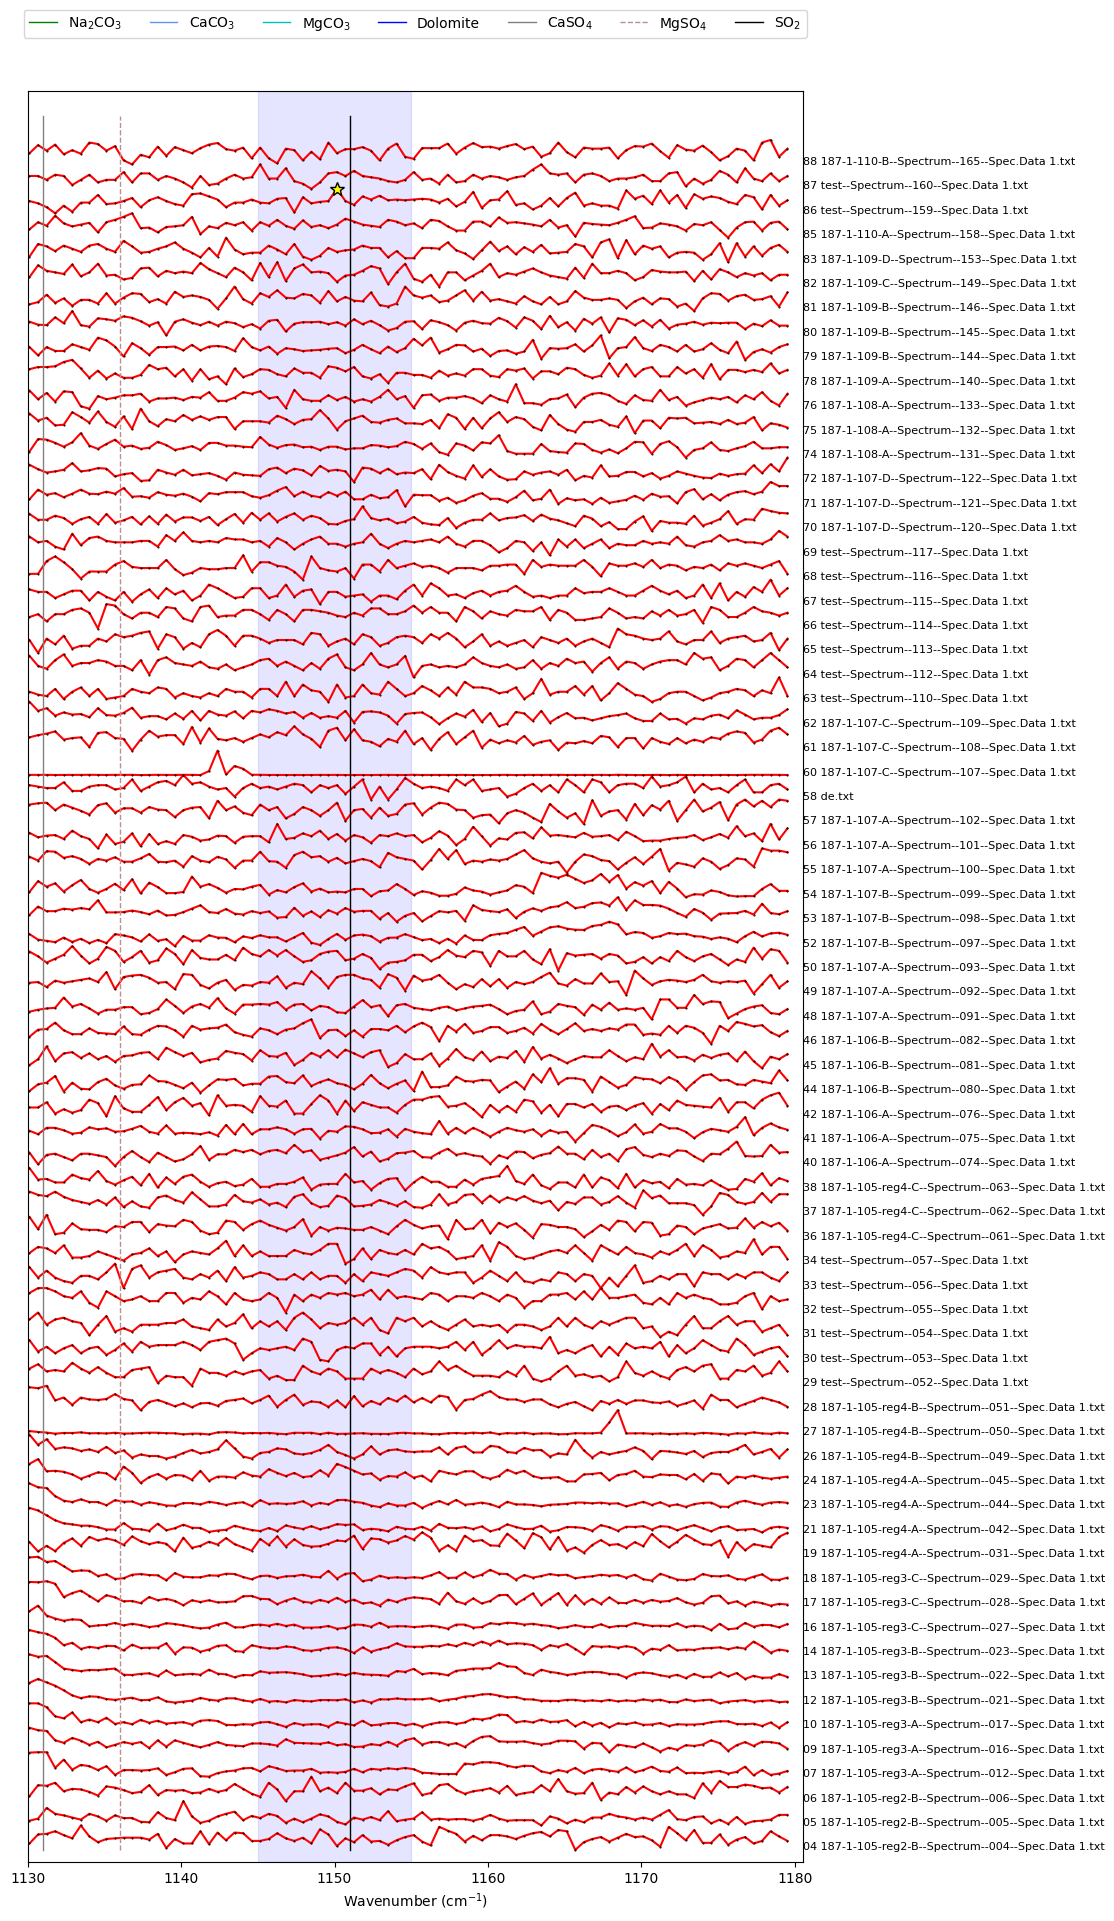

In [34]:
prominence_SO2=20
height_SO2=20
width_SO2=1
threshold_SO2=1

SO2_peaks_scipy, x_data_scipy, y_data_scipy, fig_scipy=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
filetype=spectra_filetype, find_peaks_filter=True,  
xlim_peaks=[1145, 1155], xlim_plot=[1130, 1180], yscale=0.3,
prominence=prominence_SO2, height=height_SO2, width=width_SO2, threshold=threshold_SO2)

SO2_peaks=SO2_peaks_scipy

In [35]:
SO2_peaks

pos  height  prom  \
0           NaN     NaN   NaN   
1           NaN     NaN   NaN   
2           NaN     NaN   NaN   
3           NaN     NaN   NaN   
4           NaN     NaN   NaN   
..          ...     ...   ...   
65          NaN     NaN   NaN   
66          NaN     NaN   NaN   
67  1150.154781   753.0  16.5   
68          NaN     NaN   NaN   
69          NaN     NaN   NaN   

                                           file_names  
0   04 187-1-105-reg2-B--Spectrum--004--Spec.Data ...  
1   05 187-1-105-reg2-B--Spectrum--005--Spec.Data ...  
2   06 187-1-105-reg2-B--Spectrum--006--Spec.Data ...  
3   07 187-1-105-reg3-A--Spectrum--012--Spec.Data ...  
4   09 187-1-105-reg3-A--Spectrum--016--Spec.Data ...  
..                                                ...  
65     83 187-1-109-D--Spectrum--153--Spec.Data 1.txt  
66     85 187-1-110-A--Spectrum--158--Spec.Data 1.txt  
67            86 test--Spectrum--159--Spec.Data 1.txt  
68            87 test--Spectrum--160--Spec.Data 1.txt  
69     88 187-1-110-B--Spectrum--165--Spec.Data 1.txt  

[70 rows x 4 columns]

### Now filter out ones with no peaks, or low prominence before we loop through them

In [36]:
# Remove the ones where it didnt find SO2
SO2_notNa=np.isnan(SO2_peaks['pos'])
# Remove ones with a prominence less than this. 
prom_filt=35
SO2_filter=((SO2_peaks['prom']>prom_filt))&(~SO2_notNa)
print('Number kept with this filter:')
print(sum(SO2_filter))
print('Number discarded:')
print(sum(~SO2_filter&(~SO2_notNa)))
filenames_SO2=list(File_df['filename'].loc[SO2_filter])
print('filenames with SO2:')
print(filenames_SO2)

Number kept with this filter:
0
Number discarded:
1
filenames with SO2:
[]


### Choose a filename to test peak fits

In [37]:
if sum(SO2_filter)>0:
    filename=filenames_SO2[0]

### Set up configuration file for S peak fitting
- Here, we are using a spline to quantify the area down to the 92% of the peak height (int_cut_of=0.08), there are differen options you can use for this

In [38]:
if sum(SO2_filter)>0:
    SO2_peak_config=pf.generic_peak_config(name='SO2', lower_bck=[1110, 1130],
    upper_bck=[1190, 1200], cent=1150, x_range_bck=20, N_peaks=1,   model_name='Spline', int_cut_off=0.05)
    print(SO2_peak_config)

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
    path=spectra_path, filename=filename, filetype=spectra_filetype, 
     plot_figure=True)

## Now lets loop through files

In [39]:
files_to_fit=filenames_SO2
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_SO2 = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
path=spectra_path, filename=filename, filetype=spectra_filetype,
 plot_figure=plot_figure)
 
    df_Merge_SO2 = pd.concat([df_Merge_SO2, SO2_peak_fit], axis=0)

0it [00:00, ?it/s]


In [40]:
df_Merge_SO2

Empty DataFrame
Columns: []
Index: []

### Plot peak areas and peak heights

In [41]:
if sum(SO2_filter)>0:
    plt.plot(df_Merge_SO2['Peak_Area_SO2'], 
            df_Merge_SO2['Peak_Height_SO2'], 'ok')
    plt.xlabel('Peak Area SO2')
    plt.ylabel('Peak Height SO2')
    # plt.yscale('log')
# plt.xscale('log')

### Save this to excel

In [42]:
if sum(SO2_filter)>0:
    df_Merge_SO2['filename'] = df_Merge_SO2['filename'].str.replace('--Spec.Data 1', '')
    df_Merge_SO2.to_excel('SO2_Peak_fits.xlsx', index=False)

## Now do the same to ID any carbonate peaks

### Using scipy find peaks methods
- This method doesnt always work perfectly for broader carbonate peaks

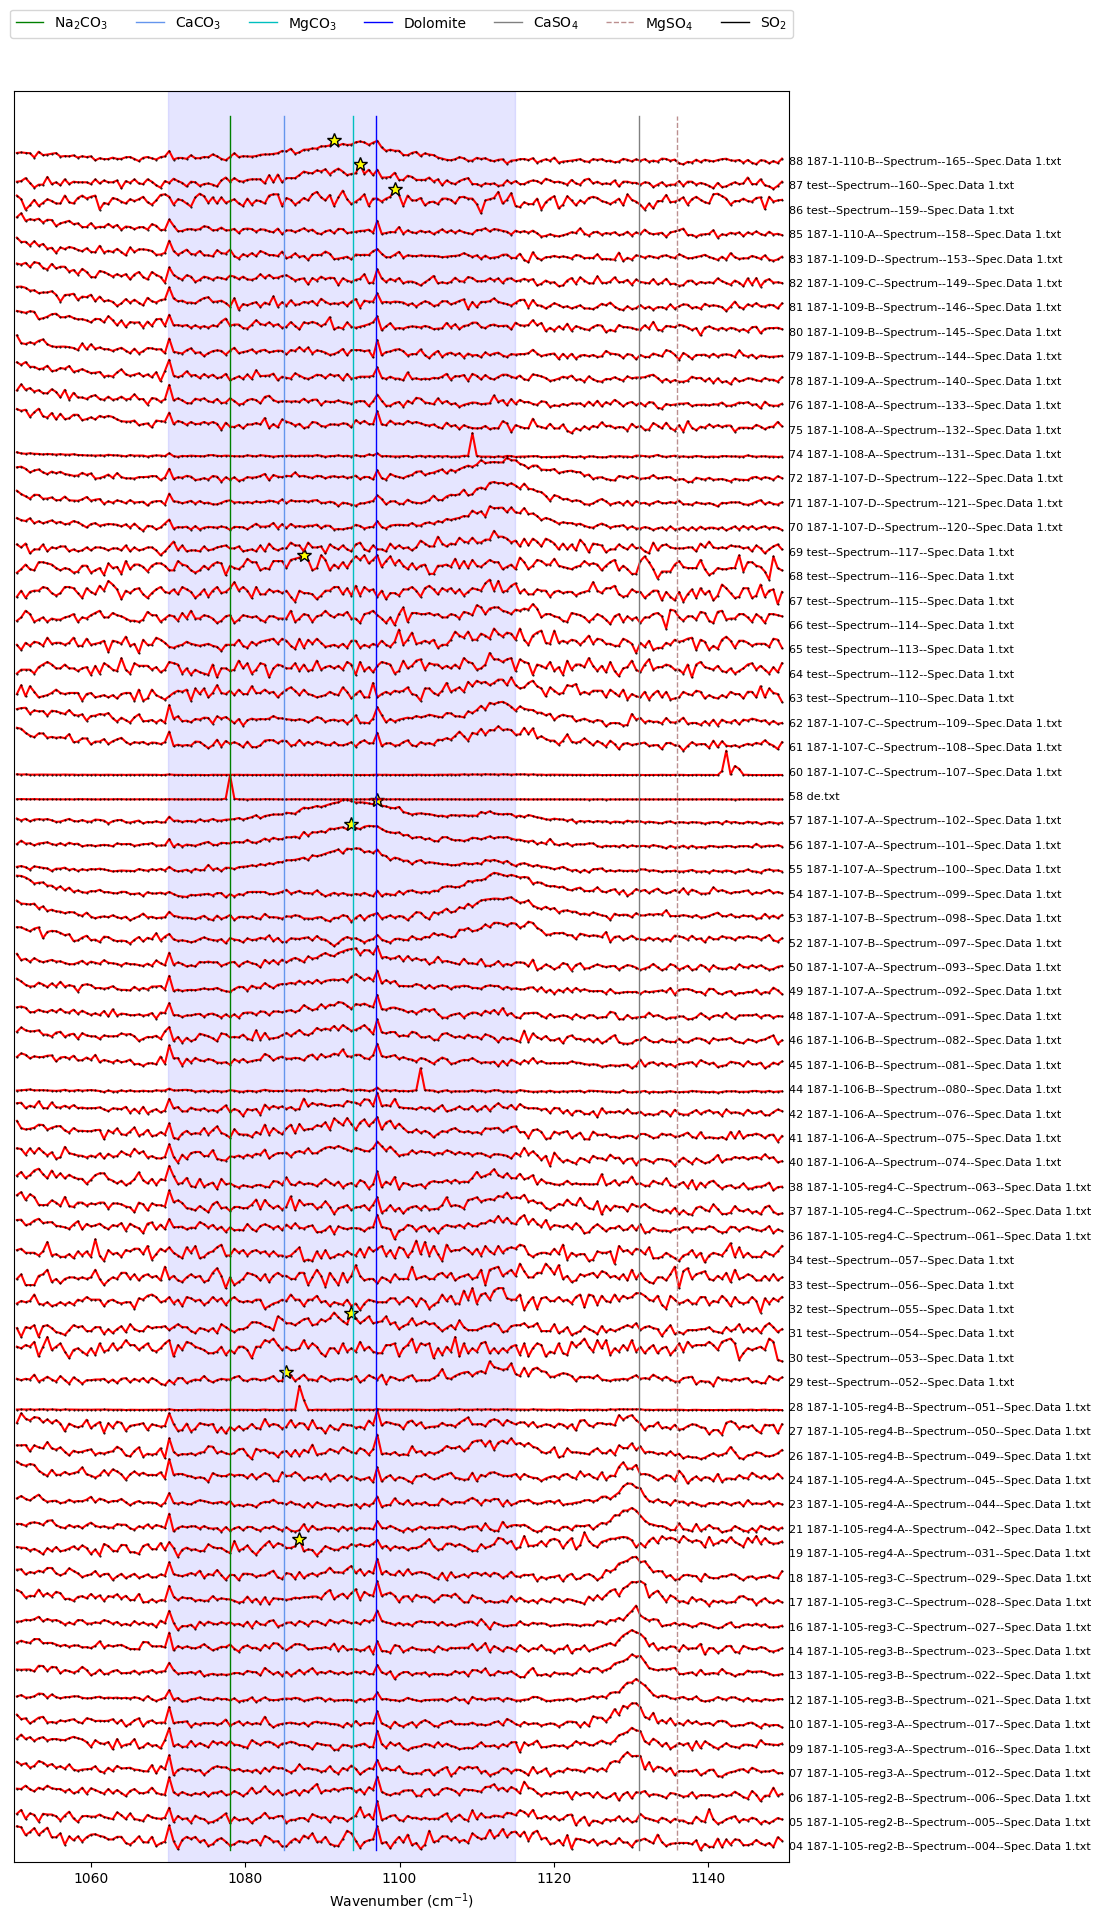

In [43]:

prominence_carb=15
height_carb=5
width_carb=2
threshold_carb=1

Carb_peaks_scipy, x_data_scipy, y_data_scipy, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=spectra_filetype, find_peaks_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1070, 1115], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)
Carb_peaks=Carb_peaks_scipy

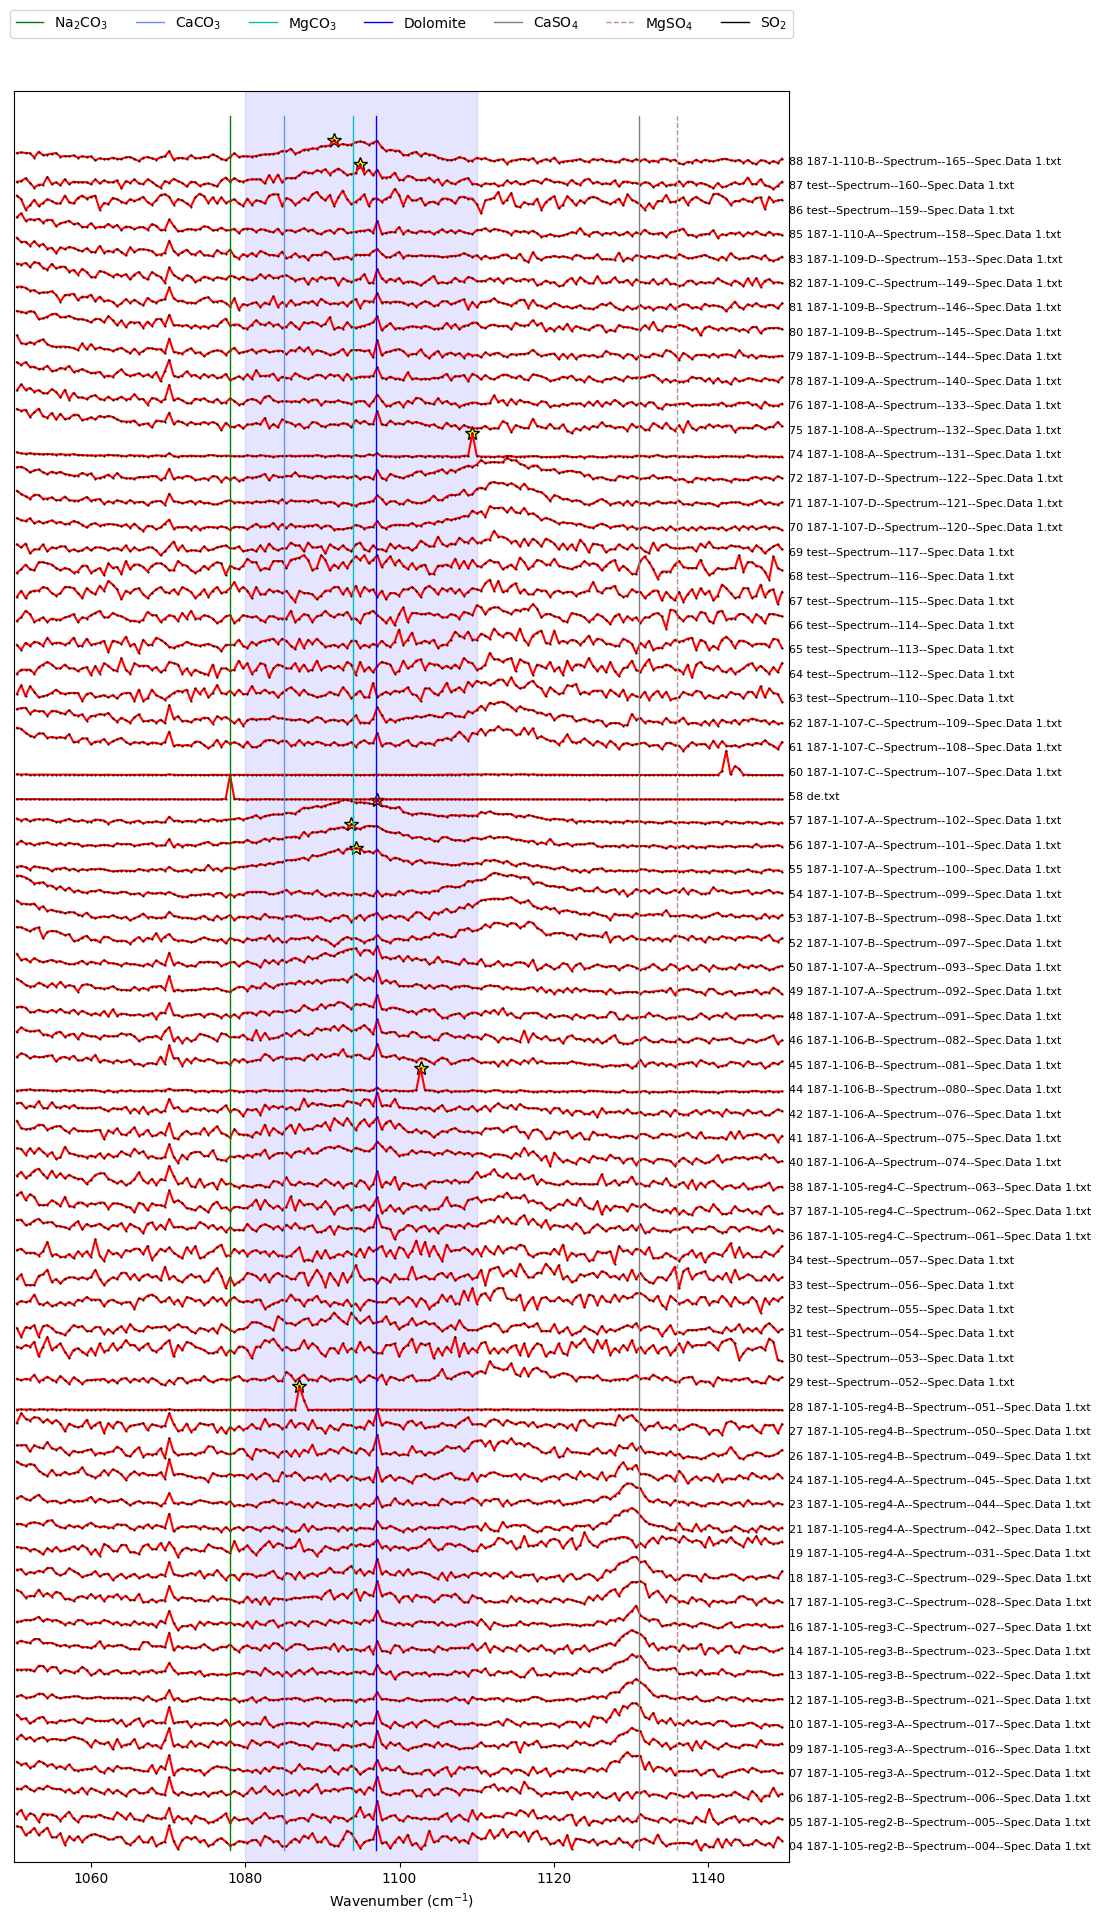

In [44]:

prominence_carb=20
height_carb=10
width_carb=1
threshold_carb=1

Carb_peaks_prom, x_data_prom, y_data_prom, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=spectra_filetype, prominence_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1080, 1110], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)

Carb_peaks=Carb_peaks_prom

In [45]:
Carb_peaks.to_clipboard(excel=True)

## Find ones with certain peak parameters to include

In [46]:
Carb_noNa=np.isnan(Carb_peaks['pos'])
prom_filter=1000
Carb_filter=((Carb_peaks['prom']<prom_filter))&(~Carb_noNa)
print('Number kept with this filter:')
print(sum(Carb_filter))
print('Number discarded:')
print(sum(~Carb_filter&(~Carb_noNa)))
filenames_Carb=list(File_df['filename'].loc[Carb_filter])
print('filenames with carb:')
print(filenames_Carb)

Number kept with this filter:
8
Number discarded:
0
filenames with carb:
['28 187-1-105-reg4-B--Spectrum--051--Spec.Data 1.txt', '44 187-1-106-B--Spectrum--080--Spec.Data 1.txt', '55 187-1-107-A--Spectrum--100--Spec.Data 1.txt', '56 187-1-107-A--Spectrum--101--Spec.Data 1.txt', '57 187-1-107-A--Spectrum--102--Spec.Data 1.txt', '74 187-1-108-A--Spectrum--131--Spec.Data 1.txt', '87 test--Spectrum--160--Spec.Data 1.txt', '88 187-1-110-B--Spectrum--165--Spec.Data 1.txt']


### Fit one to tweak parameters

generic_peak_config(name='Carb', lower_bck=[1050, 1070], upper_bck=[1120, 1150], model_name='Spline', x_range_bck=50, N_poly_carb_bck=2, amplitude=1000, cent=1090, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=None, return_other_params=False, N_peaks=1, int_cut_off=0.05)


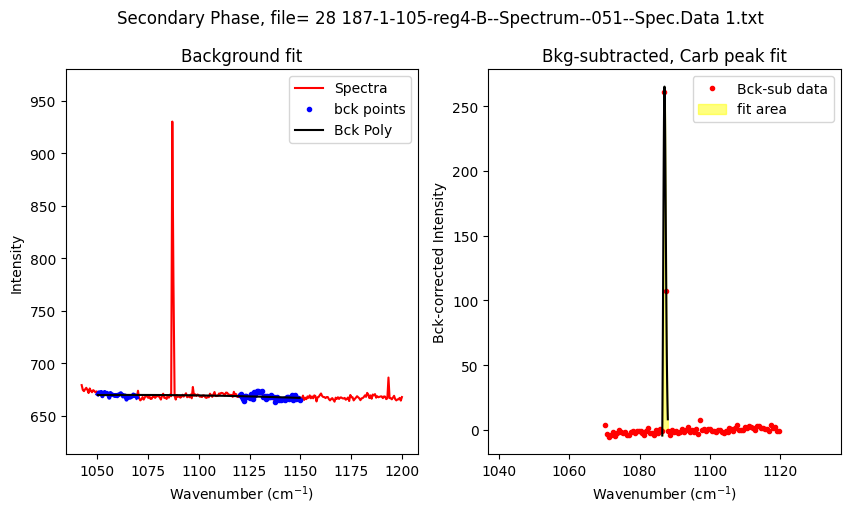

In [47]:
if sum(Carb_filter)>0:
    filename_carb=filenames_Carb[0]

    Carb_peak_config=pf.generic_peak_config(name='Carb', lower_bck=[1050, 1070],
    upper_bck=[1120, 1150], cent=1090, x_range_bck=50, N_poly_carb_bck=2, model_name='Spline')
    print(Carb_peak_config)

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
    path=spectra_path, filename=filename_carb, filetype=spectra_filetype,
     plot_figure=True)

### Loop over all carbonate files

100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


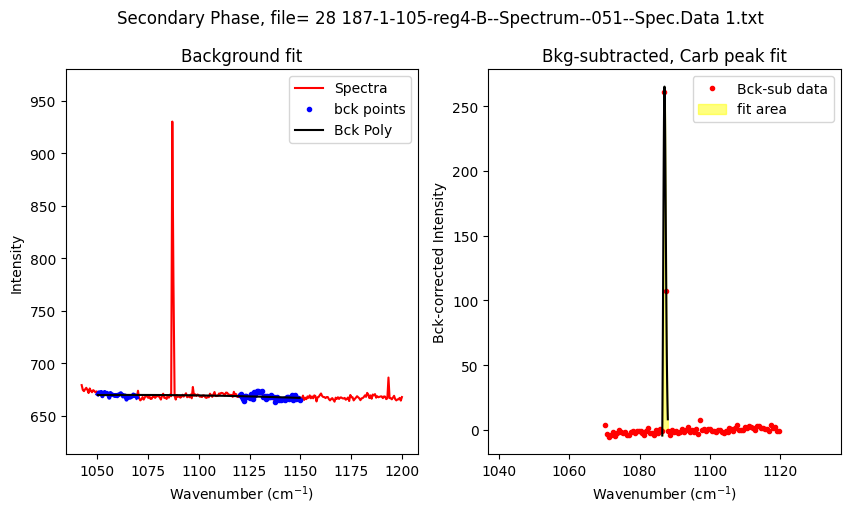

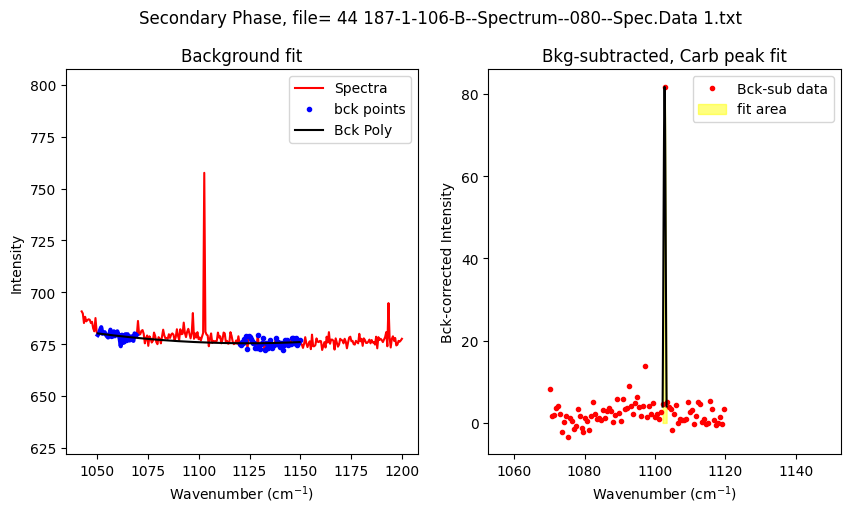

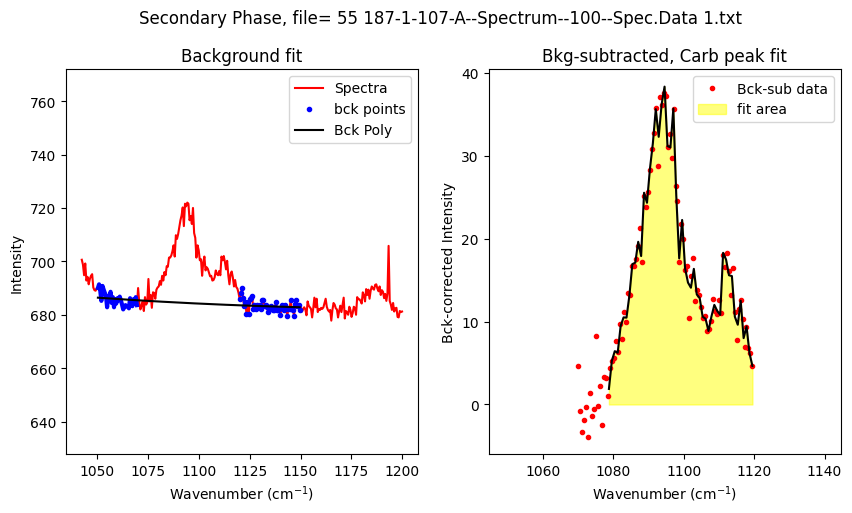

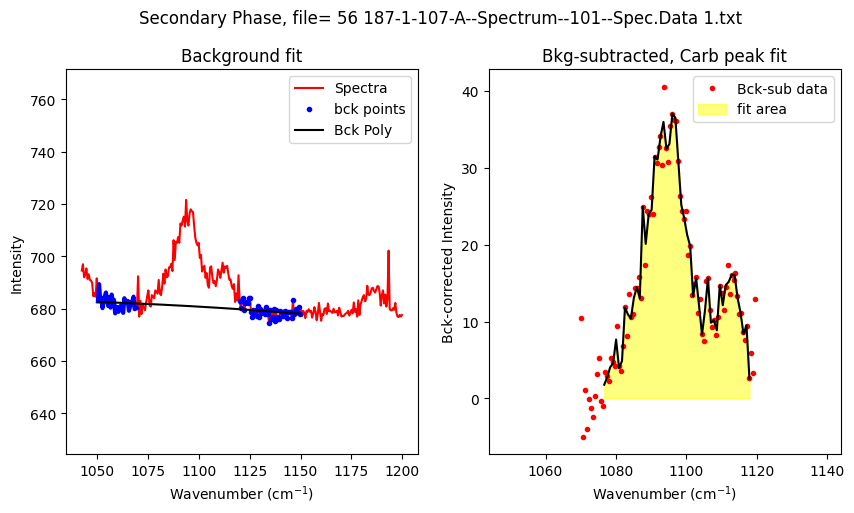

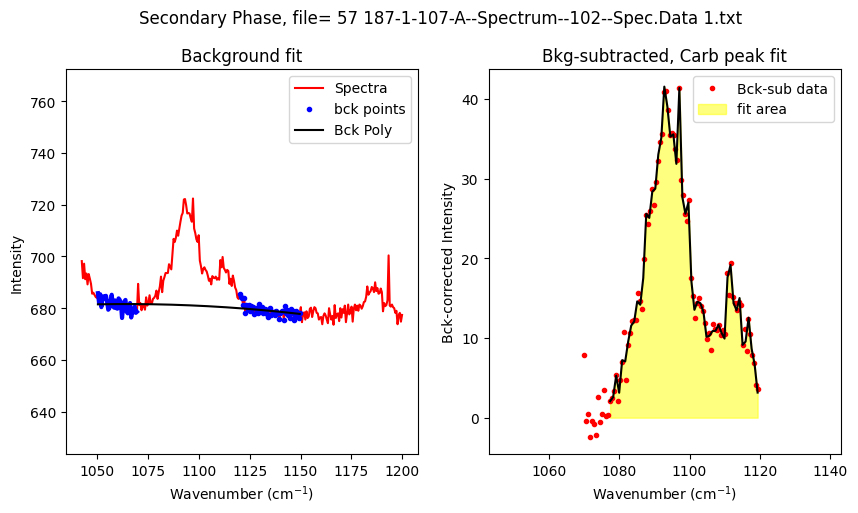

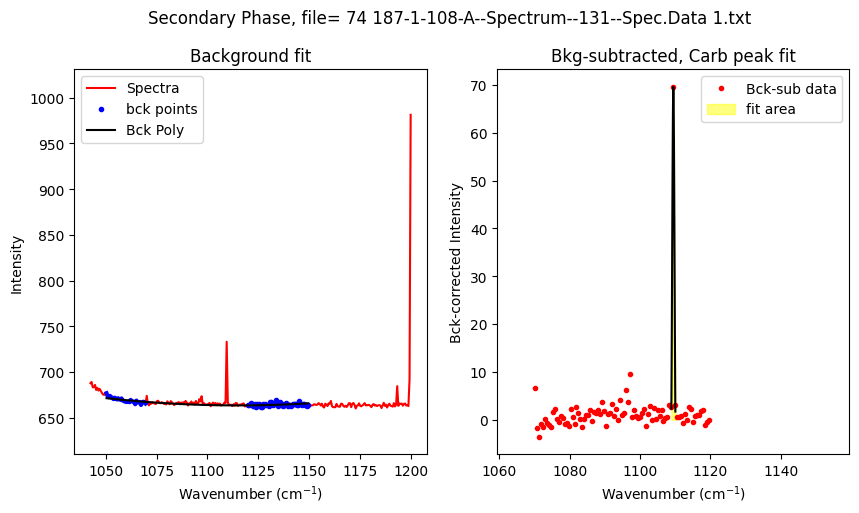

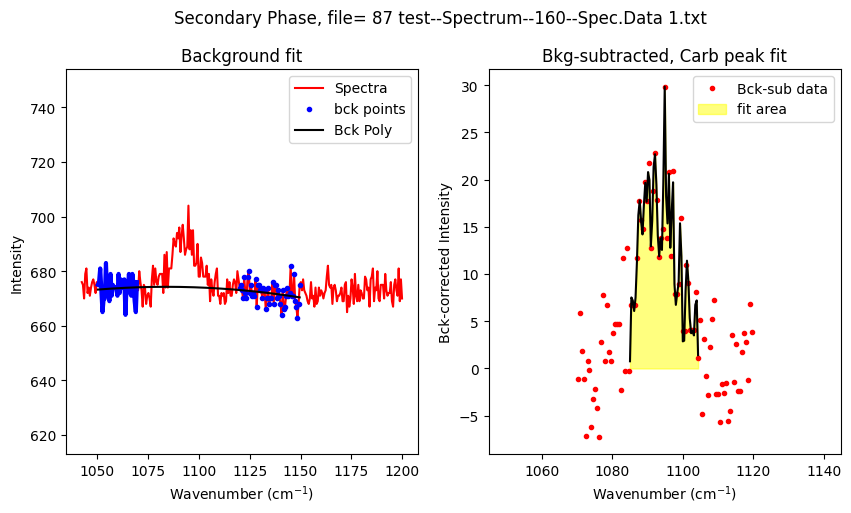

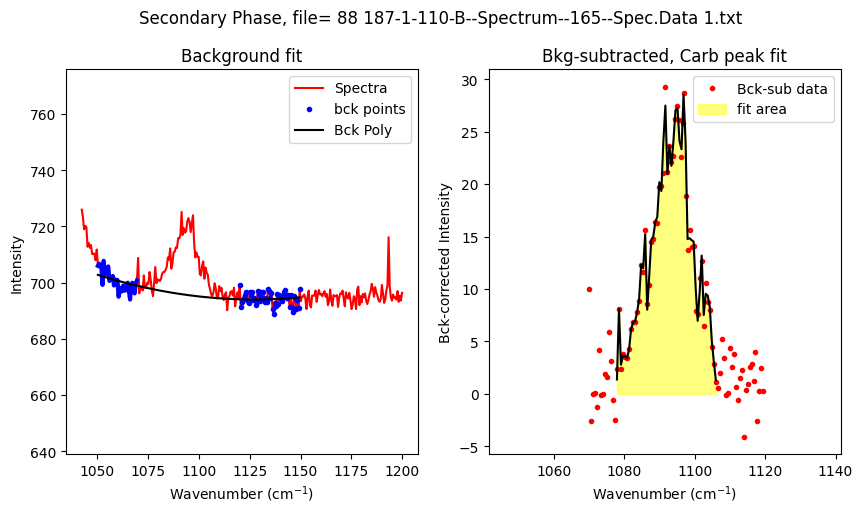

In [48]:
files_to_fit=filenames_Carb
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_Carb = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
path=spectra_path, filename=filename, filetype=spectra_filetype,
 plot_figure=plot_figure)
 
    df_Merge_Carb = pd.concat([df_Merge_Carb, Carb_peak_fit], axis=0)

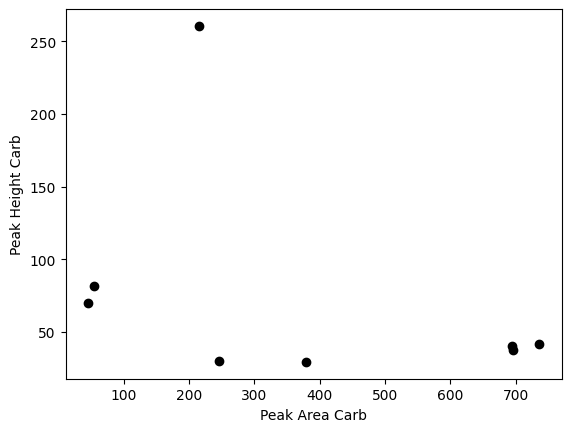

In [49]:
if sum(Carb_filter)>0:
    plt.plot(df_Merge_Carb['Peak_Area_Carb'], 
        df_Merge_Carb['Peak_Height_Carb'], 'ok')
    plt.xlabel('Peak Area Carb')
    plt.ylabel('Peak Height Carb')
# plt.yscale('log')
# plt.xscale('log')

## Save to excel

In [50]:
if sum(Carb_filter)>0:
    df_Merge_Carb['filename'] = df_Merge_Carb['filename'].str.replace('--Spec.Data 1', '')
    df_Merge_Carb.to_excel('Carb_Peak_fits.xlsx', index=False )

In [51]:
df_Merge_Carb

filename  Peak_Cent_Carb  Peak_Area_Carb  \
0  28 187-1-105-reg4-B--Spectrum--051.txt     1087.093798      215.978976   
0       44 187-1-106-B--Spectrum--080.txt     1102.712982       54.449268   
0       55 187-1-107-A--Spectrum--100.txt     1094.606823      695.844668   
0       56 187-1-107-A--Spectrum--101.txt     1093.815978      694.528325   
0       57 187-1-107-A--Spectrum--102.txt     1092.926278      736.000344   
0       74 187-1-108-A--Spectrum--131.txt     1109.435162       45.645555   
0              87 test--Spectrum--160.txt     1094.853962      245.509626   
0       88 187-1-110-B--Spectrum--165.txt     1091.492872      379.825668   

   Peak_Height_Carb Model_name  
0        260.727269     Spline  
0         81.759691     Spline  
0         37.607331     Spline  
0         40.536658     Spline  
0         41.351587     Spline  
0         69.646993     Spline  
0         29.833295     Spline  
0         29.293051     Spline

In [52]:
import os

if os.name=="posix":

    def mac_notification(title, subtitle, message):
        """
        Display a macOS notification with the default sound using AppleScript.
        
        Args:
        - title: Title of the notification.
        - subtitle: Subtitle of the notification.
        - message: Main message content of the notification.
        """
        os.system("""
                osascript -e 'display notification "{}" with title "{}" subtitle "{}" sound name "default"'
                """.format(message, title, subtitle))

    mac_notification("Notebook Completed", "VSCode", "Step3b Secondary peaks")

else:

    # %pip install winotify

    from winotify import Notification, audio

    toast= Notification(app_id="VSCode",title="Notebook completed",
                        msg="Step3b_Secondary_Peaks is done!",
                        duration="short")
    toast.set_audio(audio.Mail,loop=False)
    toast.show()